# Modeling void fraction in fluid channel using cross-sectional ellipses

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Wed April 29 17:07:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import shapely.affinity
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import unary_union

from descartes import PolygonPatch


def plot_channel(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()


## Get images to model

['w_um', 'h_um', 'd_um', 'um_per_pixel', 'buffer_um', 'min_rad_um', 'max_rad_um', 'channels']


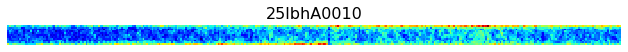

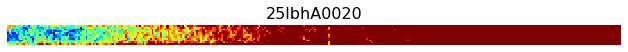

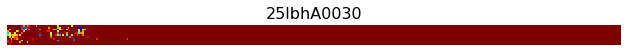

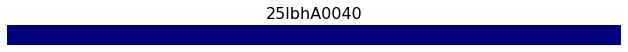

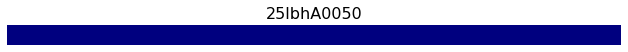

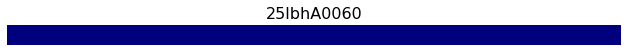

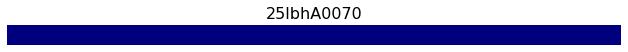

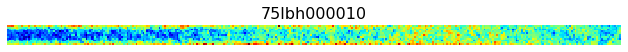

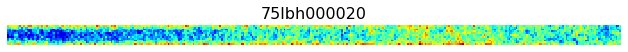

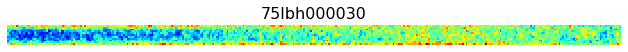

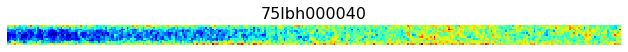

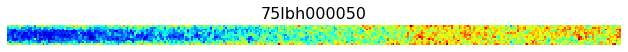

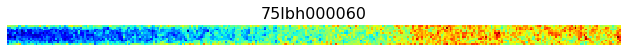

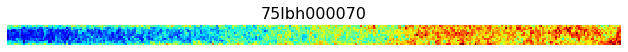

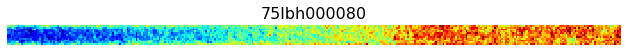

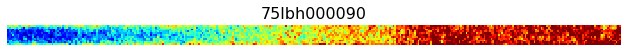

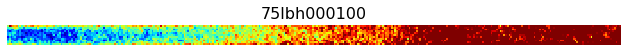

In [2]:
# navigate to data folder
data_path = os.path.join(os.getcwd(), 'data', 'compiled_data.npy')

data = np.load(data_path, allow_pickle=True)[()]
print(list(data))

# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']
    plot_channel(img, title=L)
    #print(img.shape)
    #print(img.min())
    #print(img.max())

## Automatic placement of ellipses in channel

mean residual: 67.25%


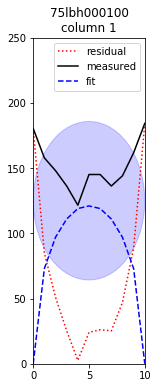

mean residual: 52.32%


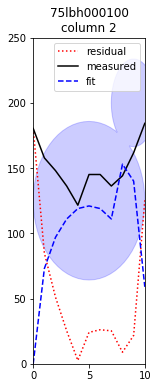

mean residual: 39.32%


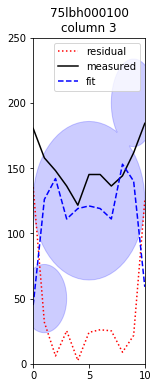

In [27]:
def multiellipse_fit(x, *params):
    """
    Use this function with scipy curve_fit for least sqquares minimization
    of ellipse packing inside a void fraction profile. Input is a list of
    initial fit parameters for the ellipses. Output is the total integral
    over all fitted ellipses.
    """
    ellipse_list = []
    for i in range(0, len(params), 4):
        # get ellipse from its properties
        circle = Point(params[i], params[i+1]).buffer(1)
        ellipse = shapely.affinity.scale(circle, params[i+2], params[i+3])
        ellipse_list.append(ellipse)
    # get union of all ellipses if they are intersecting
    union = unary_union(ellipse_list)
    # calculate total void fraction fit (integral over all ellipses) by taking
    # shapely multipolygon object and integrating over its profile to find cross section
    fit = []
    for c in range(len(cs['x'])):
        grid_points = np.column_stack((np.repeat(c, data['d_um']), np.arange(data['d_um'])))
        contains = [union.contains(Point(p)) for p in grid_points]
        fit.append(np.sum(contains))
    return union, fit

    
def get_ellipse_params(data, cs, i):
    """
    Get parameters of ellipses to populate channel with.
    Returns list like [x1, y1, rx1, ry1, ... xn, yn, rxn, ryn]
    """
    # 0th bubble: large in center of channel
    bub0 = {
        'x': cs['x'].max()/2,
        'y': data['d_um']/2,
        'rx': cs['x'].max()/2,
        'ry': cs['cs'].min()/2}
    params = list(bub0.values())
    
    
    bub1 = {
        'x': np.clip(cs['x'][np.argmax(cs['sim'])], 2, bub0['rx']),
        'y': bub0['y'] + 3/2*bub0['ry'],
        'rx': 2,
        'ry': 2} 
    params += list(bub1.values())
    
    
    '''
    
    
    params = [

        # 0th bubble: main large bubble in center of channel
        cs['x'].max()/2,
        data['d_um']/2,
        (cs['x'].max()-cs['x'].min())/2,
        cs['cs'].min()/2,
        
        # 1st bubble
        cs['x'].max()*1/8,
        data['d_um']*8.5/10,
        (cs['x'].max()-cs['x'].min()-1)/4,
        cs['cs'].min()/4,
        
        # 2nd bubble
        cs['x'].max()*7/8,
        data['d_um']*1.5/10,
        (cs['x'].max()-cs['x'].min()-1)/4,
        cs['cs'].min()/4,
    
        # 3rd bubble
        cs['x'].max()*1/10,
        data['d_um']*1.5/10,
        (cs['x'].max()-cs['x'].min()-1)*1/12,
        cs['cs'].min()/8,
        
        # 4th bubble
        cs['x'].max()*9/10,
        data['d_um']*8.5/10,
        (cs['x'].max()-cs['x'].min()-1)*1/12,
        cs['cs'].min()/8
    ]
    '''
    return params


# loop over each vertical cross section of image
for i in range(1):

    # create dataframe for holding cross section and simulated cross section
    cs = pd.DataFrame(
        np.column_stack((np.arange(img.shape[0]), img[:, i], np.zeros_like(img[:, 0]))),
        columns=['x', 'cs', 'sim'])

    
    # create initial bubble parameters
    params = [cs['x'].max()/2, data['d_um']/2, cs['x'].max()/2, cs['cs'].min()/2]
    
    # iteratively add bubbles where largest residual exists
    for i in range(3):
        
        # get cross section fit from bubbles
        union, cs['sim'] = multiellipse_fit(cs['x'], *params)

        cs['residual'] = np.abs(np.subtract(cs['cs'], cs['sim']))
        print('mean residual: {}%'.format(round(cs['residual'].mean(), 2)))

        
        if i == 0:
            params += [
                np.clip(cs['x'][np.argmax(cs['residual'])], 1, cs['x'].max()-1),
                4/5*data['d_um'],
                2,
                cs['residual'].mean()/2]
        
        if i == 1:
            params += [
                np.clip(cs['x'][np.argmax(cs['residual'])], 1, cs['x'].max()-1),
                1/5*data['d_um'],
                2,
                cs['residual'].mean()/2]
        
        
    
    
        fig, ax = plt.subplots()
        # plot residual
        plt.plot(cs['x'], cs['residual'], c='r', linestyle=':', label='residual')
        # add union of all ellipses to the plot
        ax.add_patch(PolygonPatch(union, fc='b', ec='b', alpha=0.2))
        # plot measured cross section
        plt.plot(cs['x'], cs['cs'], c='k', label='measured')
        # plot simulated cross section
        plt.plot(cs['x'], cs['sim'], c='b', linestyle='--', label='fit')
        fig.set_size_inches(2, 6)
        plt.xlim([0, np.max(cs['x'])])
        plt.ylim([0, data['d_um']])
        plt.legend()
        #plt.tight_layout()
        #plt.xticks([])
        #plt.yticks([])
        plt.title('{}\ncolumn {}'.format(L, i+1))
        #plt.savefig(os.path.join(save_img_dir, 'img_{}.jpg'.format(str(i).zfill(5))))
        plt.show()

In [22]:
params

[5.0,
 125.0,
 5.0,
 60.78431372549019,
 9.0,
 138.23529411764707,
 2,
 92.15686274509804,
 1.0,
 138.23529411764707,
 2,
 90.19607843137254]

In [4]:
'''
def get_ellipse(properties):
    """
    Get an ellipse object from its properties:
    [x0, y0, rx, ry]
    """
    circle = Point(properties['x0'], properties['y0']).buffer(1)
    ellipse = shapely.affinity.scale(circle, properties['rx'], properties['ry'])
    return ellipse

def overlapping_multi_ellipse_integral(multipolygon, xrange=10, yrange=250):
    """
    This function takes a Shapely multipolygon object
    and integrates over its profile in the x-direction.
    """
    integral = []
    for c in range(int(xrange)):
        grid_points = np.column_stack((np.repeat(c, int(yrange)), np.arange(int(yrange))))
        contains = [union.contains(Point(p)) for p in grid_points]
        integral.append(np.sum(contains))
    return integral

def multiellipse_fit(x, *params):
    """
    Use this function with scipy curve_fit for least sqquares minimization
    of ellipse packing inside a void fraction profile. Input is a list of
    initial fit parameters for the ellipses. Output is the total integral
    over all fitted ellipses.
    """
    global union
    ellipse_list = []
    for i in range(0, len(params), 4):
        # get ellipse from its properties
        circle = Point(params[i], params[i+1]).buffer(1)
        ellipse = shapely.affinity.scale(circle, params[i+2], params[i+3])
        ellipse_list.append(ellipse)
    # get union of all ellipses if they are intersecting
    union = unary_union(ellipse_list)
    # calculate total void fraction fit (integral over all ellipses)
    fit = overlapping_multi_ellipse_integral(union, len(x), data['d_um'])
    return fit



def get_guess(cs, n):
    """
    Get initial guess for fitting void fraction
    profile to multiple ellipsoidal discs. A guess is
    required for multi-peak fitting so that the number of
    fit parameters remained fixed.
    Inputs:
    cs: cross section to fit ([x, y] 2D array)
    n: number of ellipses to fit
    guess: x, y0, rx, ry
    """
    # low and high tolerance factors for each bound
    lo_tol, hi_tol = 0.5, 2
    
    
    # 0th bubble: main large bubble in center of channel
    guess = [cs['x'].max()/2,
             data['d_um']/2,
            (cs['x'].max()-cs['x'].min())/2,
            cs['cs'].min()/2]
    low_bounds = [g*lo_tol for g in guess]
    high_bounds = [g*hi_tol for g in guess]
    
    new_guesses = [
        
        # 1st bubble
        [cs['x'].max()*1/8,
        data['d_um']*8.5/10,
        (cs['x'].max()-cs['x'].min()-1)/8,
        cs['cs'].min()/4],
        
        # 2nd bubble
        [cs['x'].max()*7/8,
        data['d_um']*1.5/10,
        (cs['x'].max()-cs['x'].min()-1)/8,
        cs['cs'].min()/4],
    
        # 3rd bubble
        [cs['x'].max()*1/10,
        data['d_um']*1.5/10,
        (cs['x'].max()-cs['x'].min()-1)*1/12,
        cs['cs'].min()/8],
        
        # 4th bubble
        [cs['x'].max()*9/10,
        data['d_um']*8.5/10,
        (cs['x'].max()-cs['x'].min()-1)*1/12,
        cs['cs'].min()/8]

    ]
    
    for new_guess in new_guesses:
        guess.extend(new_guess)
        low_bounds.extend([g*lo_tol for g in new_guess])
        high_bounds.extend([g*hi_tol for g in new_guess])

    return guess, (low_bounds, high_bounds)



def multiellipse_fit_fixedy(x, *params):
    """
    Use this function with scipy curve_fit for least sqquares minimization
    of ellipse packing inside a void fraction profile. Input is a list of
    initial fit parameters for the ellipses. Output is the total integral
    over all fitted ellipses. This uses fixed y-values for each bubble.
    """
    global union
    y_vals = [
        data['d_um']/2,
        data['d_um']*8.5/10,
        data['d_um']*1.5/10,
        data['d_um']*1.5/10,
        data['d_um']*8.5/10]
    
    ellipse_list = []
    y_counter = 0
    for i in range(0, len(params), 3):
        # get ellipse from its properties
        circle = Point(params[i], y_vals[y_counter]).buffer(1)
        ellipse = shapely.affinity.scale(circle, params[i+1], params[i+2])
        ellipse_list.append(ellipse)
        y_counter += 1
    # get union of all ellipses if they are intersecting
    union = unary_union(ellipse_list)
    # calculate total void fraction fit (integral over all ellipses)
    fit = overlapping_multi_ellipse_integral(union, len(x), data['d_um'])
    return fit



def get_guess_fixedy(cs, n):
    """
    Get initial guess for fitting void fraction
    profile to multiple ellipsoidal discs. A guess is
    required for multi-peak fitting so that the number of
    fit parameters remained fixed.
    Inputs:
    cs: cross section to fit ([x, y] 2D array)
    n: number of ellipses to fit
    guess: x, rx, ry
    """
    # low and high tolerance factors for each bound
    lo_tol, hi_tol = 0.75, 1.25
    
    # 0th bubble: main large bubble in center of channel
    guess = [cs['x'].max()/2,
            (cs['x'].max()-cs['x'].min())/2,
            cs['cs'].min()/2]
    low_bounds = [g*lo_tol for g in guess]
    high_bounds = [g*hi_tol for g in guess]
    
    new_guesses = [
        # 1st bubble
        [cs['x'].max()*1/8,
        (cs['x'].max()-cs['x'].min()-1)/8,
        cs['cs'].min()/4],
        # 2nd bubble
        [cs['x'].max()*7/8,
        (cs['x'].max()-cs['x'].min()-1)/8,
        cs['cs'].min()/4],
        # 3rd bubble
        [cs['x'].max()*1/10,
        (cs['x'].max()-cs['x'].min()-1)*1/12,
        cs['cs'].min()/8],
        # 4th bubble
        [cs['x'].max()*9/10,
        (cs['x'].max()-cs['x'].min()-1)*1/12,
        cs['cs'].min()/8]
        ]
    
    for new_guess in new_guesses:
        guess.extend(new_guess)
        low_bounds.extend([g*lo_tol for g in new_guess])
        high_bounds.extend([g*hi_tol for g in new_guess])

 
    return guess, (low_bounds, high_bounds)

'''

'\ndef get_ellipse(properties):\n    """\n    Get an ellipse object from its properties:\n    [x0, y0, rx, ry]\n    """\n    circle = Point(properties[\'x0\'], properties[\'y0\']).buffer(1)\n    ellipse = shapely.affinity.scale(circle, properties[\'rx\'], properties[\'ry\'])\n    return ellipse\n\ndef overlapping_multi_ellipse_integral(multipolygon, xrange=10, yrange=250):\n    """\n    This function takes a Shapely multipolygon object\n    and integrates over its profile in the x-direction.\n    """\n    integral = []\n    for c in range(int(xrange)):\n        grid_points = np.column_stack((np.repeat(c, int(yrange)), np.arange(int(yrange))))\n        contains = [union.contains(Point(p)) for p in grid_points]\n        integral.append(np.sum(contains))\n    return integral\n\ndef multiellipse_fit(x, *params):\n    """\n    Use this function with scipy curve_fit for least sqquares minimization\n    of ellipse packing inside a void fraction profile. Input is a list of\n    initial fit par

## Fit model of multiple elliptical bubbles in channel

In [5]:
'''

# loop over each vertical cross section of image
for i in range(1):

    # create dataframe for holding cross section and simulated cross section
    cs = pd.DataFrame(
        np.column_stack((np.arange(img.shape[0]), img[:, i], np.zeros_like(img[:, 0]))),
        columns=['x', 'cs', 'sim'])


    # get fitting parameters
    #bub_num = 40
    #guess = [5, 100, 5, 100, 2, 200, 3, 20, 8, 200, 3, 20]
    guess, bounds = get_guess_fixedy(cs, 5)

    
    x_to_fit = [-1, -0.5] + list(cs['x']) + [cs['x'].max()+0.5, cs['x'].max()+1]
    y_to_fit = [0, 0] + list(cs['cs']) + [0, 0]

    
    
    popt, pcov = curve_fit(multiellipse_fit_fixedy,
                           x_to_fit, y_to_fit,
                           p0=guess, bounds=bounds,
                           #method='trf',
                           ftol=None,#1e-14,
                           xtol=1e-14,
                           gtol=None,#3e-16,
                           #loss='soft_l1'
                           verbose=2,
                           
                          )
    
    fit = multiellipse_fit_fixedy(cs['x'], *popt)
    residual = np.mean(np.abs(np.subtract(y_to_fit[2:-2], fit)))/np.mean(y_to_fit)*100
    print('residual: {}%'.format(round(residual, 2)))
    
    
    fig, ax = plt.subplots()
    # add union of all ellipses to the plot
    ax.add_patch(PolygonPatch(union, fc='b', ec='b', alpha=0.2))
    # plot measured cross section
    plt.plot(cs['x'], cs['cs'], c='k', label='measured')
    # plot simulated cross section
    plt.plot(cs['x'], fit, c='r', linestyle='--', label='fit')
    fig.set_size_inches(2, 6)
    plt.xlim([0, np.max(cs['x'])])
    plt.ylim([0, data['d_um']])
    plt.legend()
    #plt.tight_layout()
    #plt.xticks([])
    #plt.yticks([])
    plt.title('{}\ncolumn {}'.format(L, i+1))
    #plt.savefig(os.path.join(save_img_dir, 'img_{}.jpg'.format(str(i).zfill(5))))
    plt.show()

    print('bounds')
    print(np.round(bounds, 2))
    print('guess')
    print(np.reshape(guess, (-1, 3)))
    print('popt')
    print(np.reshape(popt, (-1, 3)))
'''

"\n\n# loop over each vertical cross section of image\nfor i in range(1):\n\n    # create dataframe for holding cross section and simulated cross section\n    cs = pd.DataFrame(\n        np.column_stack((np.arange(img.shape[0]), img[:, i], np.zeros_like(img[:, 0]))),\n        columns=['x', 'cs', 'sim'])\n\n\n    # get fitting parameters\n    #bub_num = 40\n    #guess = [5, 100, 5, 100, 2, 200, 3, 20, 8, 200, 3, 20]\n    guess, bounds = get_guess_fixedy(cs, 5)\n\n    \n    x_to_fit = [-1, -0.5] + list(cs['x']) + [cs['x'].max()+0.5, cs['x'].max()+1]\n    y_to_fit = [0, 0] + list(cs['cs']) + [0, 0]\n\n    \n    \n    popt, pcov = curve_fit(multiellipse_fit_fixedy,\n                           x_to_fit, y_to_fit,\n                           p0=guess, bounds=bounds,\n                           #method='trf',\n                           ftol=None,#1e-14,\n                           xtol=1e-14,\n                           gtol=None,#3e-16,\n                           #loss='soft_l1'\n         

In [6]:
'''

def get_ellipse(properties):
    """
    Get an ellipse object from its properties:
    [x0, y0, rx, ry]
    """
    circle = Point(properties['x0'], properties['y0']).buffer(1)
    ellipse = shapely.affinity.scale(circle, properties['rx'], properties['ry'])
    return ellipse

def overlapping_multi_ellipse_integral(multipolygon, xrange=10, yrange=250):
    """
    This function takes a Shapely multipolygon object
    and integrates over its profile in the x-direction.
    """
    integral = []
    for c in range(int(xrange)):
        grid_points = np.column_stack((np.repeat(c, int(yrange)), np.arange(int(yrange))))
        contains = [union.contains(Point(p)) for p in grid_points]
        integral.append(np.sum(contains))
    return integral

def multiellipse_fit(x, *params):
    """
    Use this function with scipy curve_fit for least sqquares minimization
    of ellipse packing inside a void fraction profile. Input is a list of
    initial fit parameters for the ellipses. Output is the total integral
    over all fitted ellipses.
    """
    ellipse_list = []
    for i in range(0, len(params), 4):
        # get ellipse from its properties
        circle = Point(params[i], params[i+1]).buffer(1)
        ellipse = shapely.affinity.scale(circle, params[i+2], params[i+3])
        ellipse_list.append(ellipse)
    # get union of all ellipses if they are intersecting
    union = unary_union(ellipse_list)
    # calculate total void fraction fit (integral over all ellipses)
    fit = overlapping_multi_ellipse_integral(union, len(cs['x']), data['d_um'])
    return fit



# loop over each vertical cross section of image
for i in range(1):

    # create dataframe for holding cross section and simulated cross section
    cs = pd.DataFrame(
        np.column_stack((np.arange(img.shape[0]), img[:, i], np.zeros_like(img[:, 0]))),
        columns=['x', 'cs', 'sim'])


    # get fitting parameters
    bub_num = 20
    ellipse_properties = pd.DataFrame(
        (np.random.random((bub_num, 4)))*5, columns=['x0', 'y0', 'rx', 'ry'])
    
    ellipse_properties['x0'] = np.random.randint(1, len(cs['x']-1), size=bub_num)
    ellipse_properties['y0'] = np.random.randint(20, data['d_um']-20, size=bub_num)
    ellipse_properties['rx'] = np.random.randint(1, 5, size=bub_num)
    ellipse_properties['ry'] = np.random.randint(2, 20, size=bub_num)



    ellipse_list = []
    fig, ax = plt.subplots()
    
    # loop over each bubble that we're adding to the channel
    for b in range(len(ellipse_properties)):
        
        # get ellipse from its properties
        ellipse = get_ellipse(dict(ellipse_properties.iloc[b]))
        ellipse_list.append(ellipse)


    # get union of all bubbles if they are intersecting
    union = unary_union(ellipse_list)
    print('total union area: {}'.format(round(union.area, 2)))

    # calculate total void fraction fit (integral over all ellipses)
    fit = overlapping_multi_ellipse_integral(union, len(cs['x']), data['d_um'])
    fit_area = np.trapz(fit, x=np.arange(len(fit)))
    print('total fit area: {}'.format(round(fit_area, 2)))
    
    
    
    # add union of all ellipses to the plot
    ax.add_patch(PolygonPatch(union, fc='b', ec='b', alpha=0.2))
    # plot measured cross section
    plt.plot(cs['x'], cs['cs'], c='k', label='measured')
    # plot simulated cross section
    plt.plot(cs['x'], fit, c='r', linestyle='--', label='fit')
    fig.set_size_inches(2, 6)
    plt.xlim([0, np.max(cs['x'])])
    plt.ylim([0, data['d_um']])
    plt.legend()
    #plt.tight_layout()
    #plt.xticks([])
    #plt.yticks([])
    plt.title('{}\ncolumn {}'.format(L, i+1))
    #plt.savefig(os.path.join(save_img_dir, 'img_{}.jpg'.format(str(i).zfill(5))))
    plt.show()

'''

'\n\ndef get_ellipse(properties):\n    """\n    Get an ellipse object from its properties:\n    [x0, y0, rx, ry]\n    """\n    circle = Point(properties[\'x0\'], properties[\'y0\']).buffer(1)\n    ellipse = shapely.affinity.scale(circle, properties[\'rx\'], properties[\'ry\'])\n    return ellipse\n\ndef overlapping_multi_ellipse_integral(multipolygon, xrange=10, yrange=250):\n    """\n    This function takes a Shapely multipolygon object\n    and integrates over its profile in the x-direction.\n    """\n    integral = []\n    for c in range(int(xrange)):\n        grid_points = np.column_stack((np.repeat(c, int(yrange)), np.arange(int(yrange))))\n        contains = [union.contains(Point(p)) for p in grid_points]\n        integral.append(np.sum(contains))\n    return integral\n\ndef multiellipse_fit(x, *params):\n    """\n    Use this function with scipy curve_fit for least sqquares minimization\n    of ellipse packing inside a void fraction profile. Input is a list of\n    initial fit p

In [7]:

'''

def get_multipolygon_coords(multipolygon):
    """
    Get coordinates of the boundaries of a Shapely
    multipolygon (union of polygons) object
    """
    if multipolygon.type == 'Polygon':
        print('single')
    if multipolygon.type == 'MultiPolygon':
        print('multi')
    coords = []
    for p in multipolygon:
        poly_coords = np.array([pp for pp in p.exterior._get_coords()])
        coords.append(poly_coords)
    return coords
        
coords = get_multipolygon_coords(union)

tot_int = 0

for c in coords:
    tot_int += np.trapz(c[:, 1], x=c[:, 0])

print('tot int: {}'.format(tot_int))

for c in coords:
    plt.plot(c[:, 0], c[:, 1], lw=1)
plt.show()
#[np.array([i for i in a.exterior._get_coords()]) for a in union]
'''

'\n\ndef get_multipolygon_coords(multipolygon):\n    """\n    Get coordinates of the boundaries of a Shapely\n    multipolygon (union of polygons) object\n    """\n    if multipolygon.type == \'Polygon\':\n        print(\'single\')\n    if multipolygon.type == \'MultiPolygon\':\n        print(\'multi\')\n    coords = []\n    for p in multipolygon:\n        poly_coords = np.array([pp for pp in p.exterior._get_coords()])\n        coords.append(poly_coords)\n    return coords\n        \ncoords = get_multipolygon_coords(union)\n\ntot_int = 0\n\nfor c in coords:\n    tot_int += np.trapz(c[:, 1], x=c[:, 0])\n\nprint(\'tot int: {}\'.format(tot_int))\n\nfor c in coords:\n    plt.plot(c[:, 0], c[:, 1], lw=1)\nplt.show()\n#[np.array([i for i in a.exterior._get_coords()]) for a in union]\n'